#### EP4130: Data Science Analysis

#### Assignment 7

#### Tanmay Goyal- AI20BTECH11021

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import emcee
import corner
import dynesty
from dynesty import NestedSampler
from sklearn.neighbors import KernelDensity as kde

**Question 1**

Download the data from http://iith.ac.in/~shantanud/fgas_spt.txt. Fit the data to $f_0(1+f_1z)$ where $f_0$ and $f_1$ are unknown parameters. Determine the best fit values of $f_0$ and $f_1$ including 68% and 95% confidence intervals. The priors on $f_0$ and $f_1$ are $0 < f_0 < 0.5$ and $-0.5 < f_1 < 0.5$

In [2]:
data = pd.read_csv("fgas_spt.txt")
z = data["z"]
f_gas = data["fgas"]
fgas_err = data["fgas_error"]

In [3]:
# defining the log prior
# the prior is 1 if 0 < f0 < 0.5 and -0.5 < f1 < 0.5
# taking the log gives us 0 and -inf
def log_prior(theta):
    f0 , f1 = theta
    if 0 < f0 < 0.5 and -0.5 < f1 < 0.5:
        return 0.0
    return -np.inf

In [4]:
# defining the log likelihood
def log_likelihood(theta, z, f_gas, fgas_err):
    f0, f1 = theta
    model = f0 + f1 * z
    return -0.5 * np.sum(((f_gas - model) / fgas_err)**2)

In [5]:
# defining the log posterior
def log_posterior(theta, z, f_gas, fgas_err):
    return log_prior(theta) + log_likelihood(theta, z, f_gas, fgas_err)

In [6]:
# running MCMC

# number of chains
nwalkers = 50
# number of steps
nsteps = 2000
# number of dimensions
ndim = 2
# burn-in period
nburn = 1000

# initial guess for parameters
f0_guess = np.random.uniform(0 , 0.5 , nwalkers)
f1_guess = np.random.uniform(-0.5 , 0.5 , nwalkers)
initial = np.vstack((f0_guess , f1_guess)).T

# defining the sampler
sampler = emcee.EnsembleSampler(nwalkers , ndim , log_posterior , args = (z , f_gas , fgas_err))
sampler.run_mcmc(initial , nsteps)
samples = sampler.chain[: , nburn: , :].reshape(-1 , ndim)

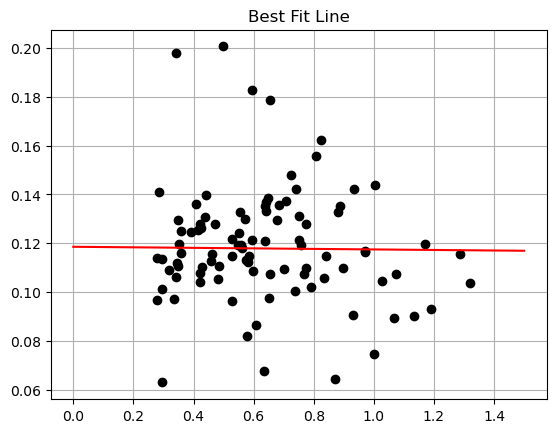

In [7]:
f0 = samples[:,0].mean()
f1 = samples[:,1].mean()
x = np.linspace(0,1.5,100)
plt.plot(z , f_gas , 'ko')
plt.title("Best Fit Line")
plt.plot(x , f0 * (1 + f1*x) , 'r-')
plt.grid(True)
plt.show()

68% and 95% joint confidence intervals for f_0 and f_1


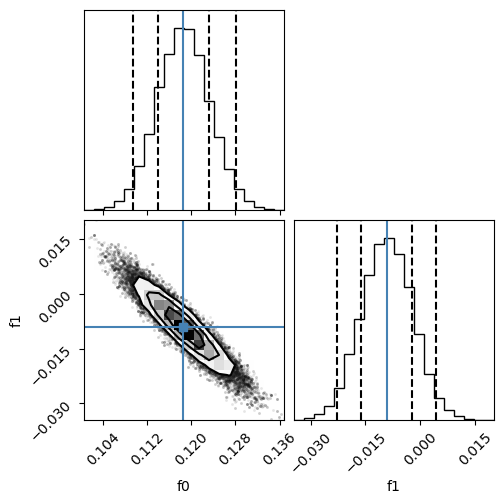

In [8]:
print("68% and 95% joint confidence intervals for f_0 and f_1")
corner.corner(samples , labels = ["f0" , "f1"] , truths = [f0 , f1] , quantiles = (0.16 , 0.84 , 0.025 , 0.975))
plt.show()

**Question 2**

Calculate the Bayes Factor for the linear and quadratic models for the example given on the fifth blog article of the Pythonic Perambulations Series. Do the values agree with the values given on the blog?

In [9]:
data = np.array([[0.42,  0.72,  0.,  0.3,  0.15,0.09,  0.19,  0.35,  0.4,  0.54,
                  0.42,  0.69,  0.2,  0.88,  0.03,0.67,  0.42,  0.56,  0.14,  0.2],
                 [0.33,  0.41, -0.22,  0.01, -0.05, -0.05, -0.12,  0.26,  0.29,  0.39,
                  0.31,  0.42, -0.01,  0.58, -0.2, 0.52,  0.15,  0.32, -0.13, -0.09],
                 [0.1,  0.1,  0.1,  0.1,  0.1, 0.1,  0.1,  0.1,  0.1,  0.1,
                  0.1,  0.1,  0.1,  0.1,  0.1, 0.1,  0.1,  0.1,  0.1,  0.1]])

x , y , sigma_y = data

In [10]:
# function for polynomial fit
def polynomial_fit(theta):
    sum = 0
    for idx , coeff in enumerate(theta):
        sum += coeff * x ** idx
    return sum

# function for log likelihood
def log_likelyhood(theta, data=data):
    pred = polynomial_fit(theta)
    # assumign Gaussian Likelihood
    return -0.5 * np.sum(np.log(2 * np.pi * sigma_y ** 2) + (y - pred) ** 2 / sigma_y ** 2)

# function for prior
def prior(theta):
    return 200*theta - 100

In [11]:
# Taking reference from 
# http://mattpitkin.github.io/samplers-demo/pages/samplers-samplers-everywhere/#dynesty

nlive = 1024      # number of live points
bound = 'multi'   # use MutliNest algorithm for bounds
ndims = 2         # two parameters
sample = 'unif'   # uniform sampling
tol = 0.1         # the stopping criterion


sampler = NestedSampler(log_likelyhood, prior, ndims,
                        bound=bound, sample=sample, nlive=nlive)

sampler.run_nested(dlogz=tol, print_progress=False) # don't output progress bar

res = sampler.results # get results dictionary from sampler

logZdynesty_linear = res.logz[-1]        # value of logZ
logZerrdynesty_linear = res.logzerr[-1]  # estimate of the statistcal uncertainty on logZ

print("log(Z) for the Linear Model = {} ± {}".format(logZdynesty_linear, logZerrdynesty_linear))

log(Z) for the Linear Model = 7.2004769593739955 ± 0.14707847411481267


In [12]:
# Taking reference from 
# http://mattpitkin.github.io/samplers-demo/pages/samplers-samplers-everywhere/#dynesty

nlive = 1024      # number of live points
bound = 'multi'   # use MutliNest algorithm for bounds
ndims = 3         # three parameters
sample = 'unif'   # uniform sampling
tol = 0.1         # the stopping criterion


sampler = NestedSampler(log_likelyhood, prior, ndims,
                        bound=bound, sample=sample, nlive=nlive)

sampler.run_nested(dlogz=tol, print_progress=False) # don't output progress bar

res = sampler.results # get results dictionary from sampler

logZdynesty_quadratic = res.logz[-1]        # value of logZ
logZerrdynesty_quadratic = res.logzerr[-1]  # estimate of the statistcal uncertainty on logZ

print("log(Z) for the Quadratic Model = {} ± {}".format(logZdynesty_quadratic, logZerrdynesty_quadratic))

log(Z) for the Quadratic Model = 2.755208318781224 ± 0.17063782035896463


In [13]:
print("The Bayes Factor for the quadratic model is given by: {}.\
\nThis does not agree with the Blog."\
.format(np.exp(logZdynesty_quadratic) / np.exp(logZdynesty_linear)))

The Bayes Factor for the quadratic model is given by: 0.011733953391303342.
This does not agree with the Blog.


**Question 3**

Download the SDSS quasar dataset from http://astrostatistics.psu.edu/datasets/SDSS_quasar.dat . Plot the KDE estimate of the quasar redshift distribution (column $z$) using a Gaussian and also an exponential kernel (with bandwidth = 0.2) from -0.5 to 5.5.


In [14]:
# cleaning the data up by removing multiple spaces and replacing them with single space
data = pd.read_csv("SDSS_quasar.txt" , sep = " ")
data

,SDSS_J,R.A.,Dec.,z,u_mag,sig_u,g_mag,sig_g,r_mag,sig_r,...,sig_z,Radio,X-ray,J_mag,sig_J,H_mag,sig_H,K_mag,sig_K,M_i
0,000009.26+151754.5,0.038605,15.298476,1.1986,19.921,0.042,19.811,0.036,19.386,0.017,...,0.069,-1.0,-9.000,0.000,0.000,0.000,0.000,0.000,0.000,-25.085
1,000009.38+135618.4,0.039088,13.938447,2.2400,19.218,0.026,18.893,0.022,18.445,0.018,...,0.033,-1.0,-9.000,0.000,0.000,0.000,0.000,0.000,0.000,-27.419
2,000009.42-102751.9,0.039269,-10.464428,1.8442,19.249,0.036,19.029,0.027,18.980,0.021,...,0.047,0.0,-9.000,0.000,0.000,0.000,0.000,0.000,0.000,-26.459
3,000011.41+145545.6,0.047547,14.929353,0.4596,19.637,0.030,19.466,0.024,19.362,0.022,...,0.047,-1.0,-9.000,0.000,0.000,0.000,0.000,0.000,0.000,-22.728
4,000011.96+000225.3,0.049842,0.040372,0.4790,18.237,0.028,17.971,0.020,18.025,0.019,...,0.029,0.0,-1.660,16.651,0.136,15.820,0.149,14.821,0.111,-24.046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46415,235949.46+150430.6,359.956093,15.075185,0.2977,19.094,0.025,18.966,0.023,18.668,0.016,...,0.033,-1.0,-1.429,16.676,0.180,15.661,0.176,15.187,0.130,-22.286
46416,235953.44-093655.6,359.972672,-9.615454,0.3585,19.509,0.045,19.276,0.022,18.895,0.018,...,0.039,0.0,-9.000,16.976,0.173,16.188,0.164,15.502,0.238,-22.549
46417,235956.72+135131.7,359.986358,13.858825,2.3826,20.010,0.040,19.427,0.027,19.217,0.018,...,0.048,-1.0,-9.000,0.000,0.000,0.000,0.000,0.000,0.000,-26.665
46418,235958.21+005139.8,359.992546,0.861062,2.0382,19.256,0.034,19.004,0.021,18.794,0.017,...,0.036,0.0,-9.000,0.000,0.000,0.000,0.000,0.000,0.000,-26.900


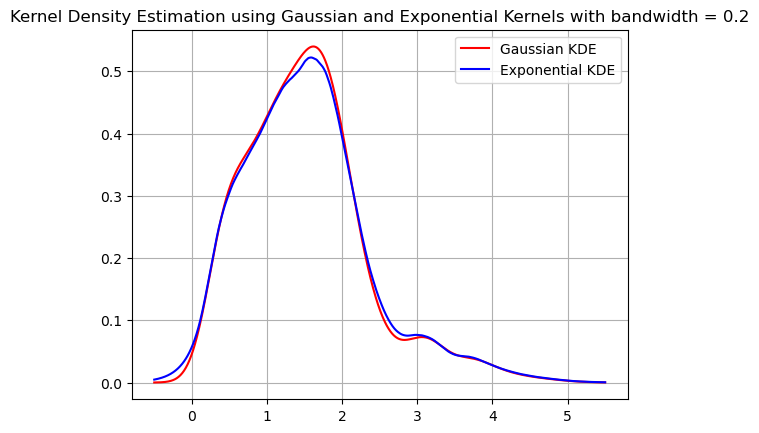

In [15]:
quasar = data["z"]
quasar = quasar.to_numpy().reshape(-1,1)
x = np.linspace(-0.5 , 5.5 , 1000)

gaussian_kde = kde(kernel = "gaussian" , bandwidth = 0.2).fit(quasar)
exponential_kde = kde(kernel = "exponential" , bandwidth = 0.2).fit(quasar)

# we take np.exp by taking reference from sklearn documentation for KDE
plt.plot(x , np.exp(gaussian_kde.score_samples(x.reshape(-1,1))) , 'r-' , label = "Gaussian KDE")
plt.plot(x , np.exp(exponential_kde.score_samples(x.reshape(-1,1))) , 'b-' , label = "Exponential KDE")
plt.grid(True)
plt.legend()
plt.title("Kernel Density Estimation using Gaussian and Exponential Kernels with bandwidth = 0.2")
plt.show()